# Titanic: Machine Learning from Disaster - Exploratory Data Analysis

The input files are available from the [download](https://www.kaggle.com/c/titanic/data) section of the contest:

**Data Dictionary**
- survival (Survival): 0 = No, 1 = Yes
- pclass (Ticket class): 1 = 1st, 2 = 2nd, 3 = 3rd
- sex (Sex)	
- Age (Age in years)	
- sibsp (# of siblings / spouses aboard the Titanic)
- parch (# of parents / children aboard the Titanic)
- ticket (Ticket number)
- fare (Passenger fare)
- cabin (Cabin number)
- embarked (Port of Embarkation): C = Cherbourg, Q = Queenstown, S = Southampton

**Variable Notes**
- pclass: A proxy for socio-economic status (SES)
    - 1st = Upper
    - 2nd = Middle
    - 3rd = Lower
- age: Age is fractional if less than 1. If the age is estimated, is it in the form of xx.5
- sibsp: The dataset defines family relations in this way...
    - Sibling = brother, sister, stepbrother, stepsister
    - Spouse = husband, wife (mistresses and fiancés were ignored)

- parch: The dataset defines family relations in this way...
    - Parent = mother, father
    - Child = daughter, son, stepdaughter, stepson

Some children travelled only with a nanny, therefore parch=0 for them.

Inspired by [A Data Science Framework: To Achieve 99% Accuracy](https://www.kaggle.com/ldfreeman3/a-data-science-framework-to-achieve-99-accuracy)

## Data import

In [58]:
import gc
import time
import random
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
import lightgbm as lgb
from scipy import interp
from itertools import cycle
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.manifold import TSNE
from xgboost import XGBClassifier
from sklearn import model_selection
from sklearn import feature_selection
from sklearn.decomposition import PCA
from catboost import CatBoostRegressor
from sklearn.linear_model import Ridge
from sklearn.model_selection import StratifiedKFold, KFold, train_test_split
from sklearn.metrics import confusion_matrix, roc_auc_score, mean_squared_error, roc_curve, auc
from sklearn import svm, tree, linear_model, neighbors, naive_bayes, ensemble, discriminant_analysis, gaussian_process

random.seed(1)
warnings.filterwarnings("ignore")

sns.set(rc={'figure.figsize':(15, 6)})

In [2]:
def reduce_memory_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Starting memory usage: {:5.2f} MB'.format(start_mem))

    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min >= np.iinfo(np.int8).min and c_max <= np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min >= np.iinfo(np.int16).min and c_max <= np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min >= np.iinfo(np.int32).min and c_max <= np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min >= np.iinfo(np.int64).min and c_max <= np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min >= np.finfo(np.float16).min and c_max <= np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min >= np.finfo(np.float32).min and c_max <= np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Reduced memory usage: {:5.2f} MB ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [3]:
df_train = pd.read_csv('input/train.csv', index_col='PassengerId', usecols=['PassengerId', 'Survived', 'Name', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Cabin', 'Embarked'])
df_train = reduce_memory_usage(df_train)
print("{:,} records and {} features in train set.".format(df_train.shape[0], df_train.shape[1]))

Starting memory usage:  0.07 MB
Reduced memory usage:  0.04 MB (45.5% reduction)
891 records and 10 features in train set.


In [4]:
df_test = pd.read_csv('input/test.csv', index_col='PassengerId', usecols=['PassengerId', 'Name', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Cabin', 'Embarked'])
df_test = reduce_memory_usage(df_test)
print("{:,} records and {} features in test set.".format(df_test.shape[0], df_test.shape[1]))

Starting memory usage:  0.03 MB
Reduced memory usage:  0.02 MB (41.2% reduction)
418 records and 9 features in test set.


## Exploratory Data Analysis

In [5]:
df_train[:3]

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.250000,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.312500,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.925781,NaN,S


In [6]:
df_train.count()

Survived    891
Pclass      891
Name        891
Sex         891
Age         714
SibSp       891
Parch       891
Fare        891
Cabin       204
Embarked    889
dtype: int64

In [7]:
df_test.count()

Pclass      418
Name        418
Sex         418
Age         332
SibSp       418
Parch       418
Fare        417
Cabin        91
Embarked    418
dtype: int64

### Age

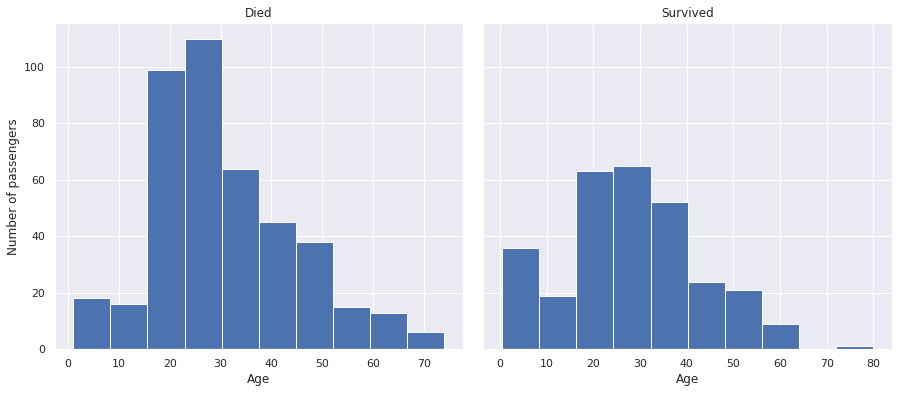

In [8]:
fig, ax = plt.subplots(1, 2, sharey='row', figsize=(15, 6))
fig.subplots_adjust(wspace=0.05)

ax[0].set_title("Died")
ax[0].set_xlabel('Age')
ax[0].set_ylabel('Number of passengers')
df_train[df_train['Survived'] == 0]['Age'].hist(bins=10, ax=ax[0])

ax[1].set_title("Survived")
ax[1].set_xlabel('Age')
df_train[df_train['Survived'] == 1]['Age'].hist(bins=10, ax=ax[1])

In [9]:
mean_d = df_train[df_train['Survived'] == 0]['Age'].mean()
mean_s = df_train[df_train['Survived'] == 1]['Age'].mean()
print('Average age of the died passangers: {:.2f}'.format(mean_d))
print('Average age of the survived passangers: {:.2f}'.format(mean_s))

Average age of the died passangers: 30.62
Average age of the survived passangers: 28.33


In [10]:
df_train[df_train['Survived'] == 0]['Age'] = mean_d
df_train[df_train['Survived'] == 1]['Age'] = mean_s

In [11]:
df_train[df_train['Age'].isna()][:3]

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,
6,0,3,"Moran, Mr. James",male,NaN,0,0,8.460938,NaN,Q
18,1,2,"Williams, Mr. Charles Eugene",male,NaN,0,0,13.000000,NaN,S
20,1,3,"Masselmani, Mrs. Fatima",female,NaN,0,0,7.226562,NaN,C


### Cabin

In [12]:
len(df_train[(df_train['Survived'] == 0)&(df_train['Cabin'].isna())]), len(df_train[(df_train['Survived'] == 0)&(df_train['Cabin'].isna() == False)])

(481, 68)

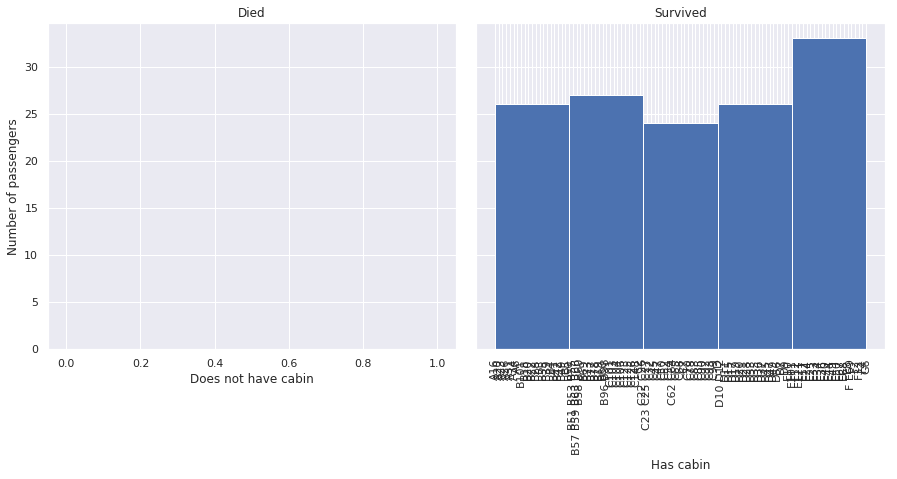

In [13]:
fig, ax = plt.subplots(1, 2, sharey='row', figsize=(15, 6))
fig.subplots_adjust(wspace=0.05)

ax[0].set_title('Died')
ax[0].set_xlabel('Does not have cabin')
ax[0].set_ylabel('Number of passengers')
df_train[(df_train['Survived'] == 0)&(df_train['Cabin'].isna())]['Cabin'].hist(ax=ax[0])

ax[1].set_title('Survived')
ax[1].set_xlabel('Has cabin')
plt.xticks(rotation=90)
df_train[(df_train['Survived'] == 1)&(df_train['Cabin'].isna() == False)]['Cabin'].hist(bins=5, ax=ax[1])

### Embarked

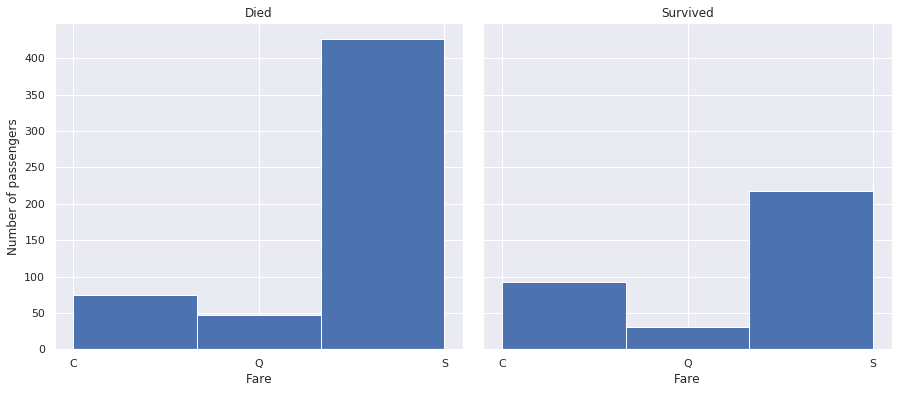

In [14]:
fig, ax = plt.subplots(1, 2, sharey='row', figsize=(15, 6))
fig.subplots_adjust(wspace=0.05)

ax[0].set_title('Died')
ax[0].set_xlabel('Fare')
ax[0].set_ylabel('Number of passengers')
df_train[df_train['Survived'] == 0]['Embarked'].hist(bins=3, ax=ax[0])

ax[1].set_title('Survived')
ax[1].set_xlabel('Fare')
df_train[df_train['Survived'] == 1]['Embarked'].hist(bins=3, ax=ax[1])

In [15]:
df_train['Embarked'].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

### Fare

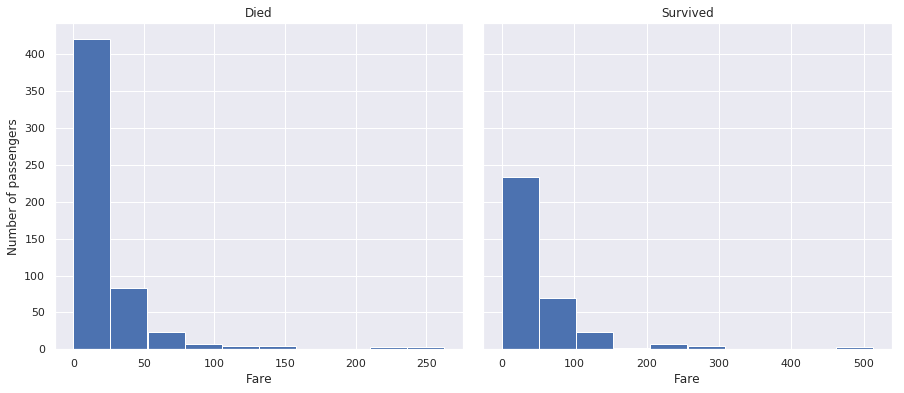

In [16]:
fig, ax = plt.subplots(1, 2, sharey='row', figsize=(15, 6))
fig.subplots_adjust(wspace=0.05)

ax[0].set_title('Died')
ax[0].set_xlabel('Fare')
ax[0].set_ylabel('Number of passengers')
df_train[df_train['Survived'] == 0]['Fare'].hist(ax=ax[0])

ax[1].set_title('Survived')
ax[1].set_xlabel('Fare')
df_train[df_train['Survived'] == 1]['Fare'].hist(ax=ax[1])

### PClass

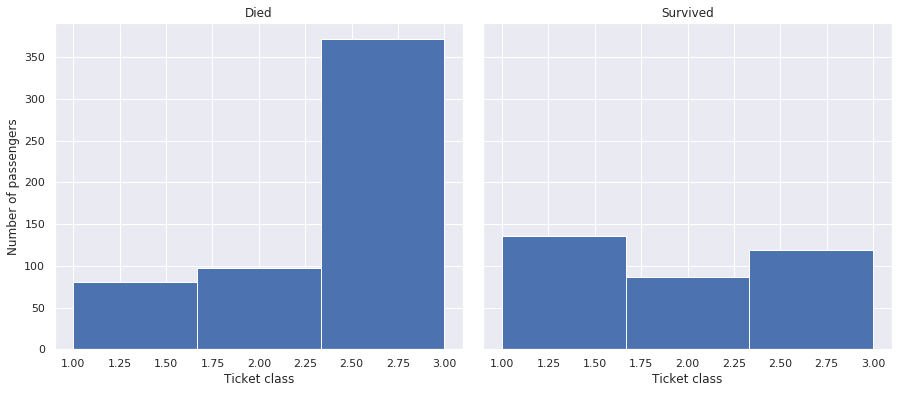

In [17]:
fig, ax = plt.subplots(1, 2, sharey='row', figsize=(15, 6))
fig.subplots_adjust(wspace=0.05)

ax[0].set_title('Died')
ax[0].set_xlabel('Ticket class')
ax[0].set_ylabel('Number of passengers')
df_train[df_train['Survived'] == 0]['Pclass'].hist(bins=3, ax=ax[0])

ax[1].set_title('Survived')
ax[1].set_xlabel('Ticket class')
df_train[df_train['Survived'] == 1]['Pclass'].hist(bins=3, ax=ax[1])

### Sex

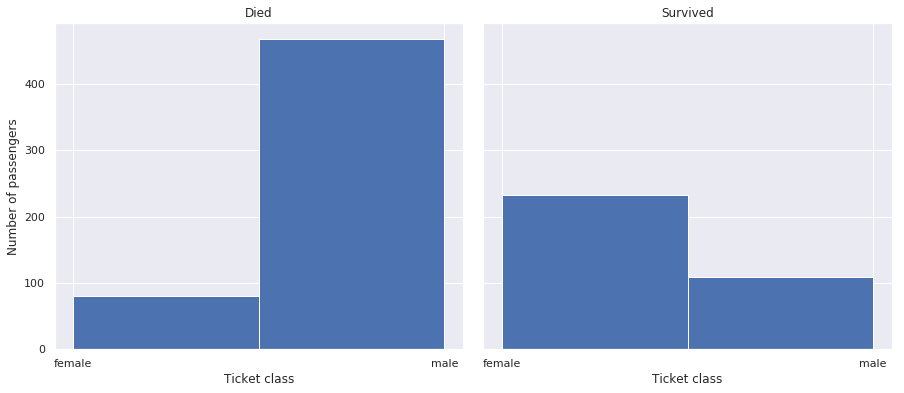

In [18]:
fig, ax = plt.subplots(1, 2, sharey='row', figsize=(15, 6))
fig.subplots_adjust(wspace=0.05)

ax[0].set_title('Died')
ax[0].set_xlabel('Ticket class')
ax[0].set_ylabel('Number of passengers')
df_train[df_train['Survived'] == 0]['Sex'].hist(bins=2, ax=ax[0])

ax[1].set_title('Survived')
ax[1].set_xlabel('Ticket class')
df_train[df_train['Survived'] == 1]['Sex'].hist(bins=2, ax=ax[1])

### Siblings/Spouse

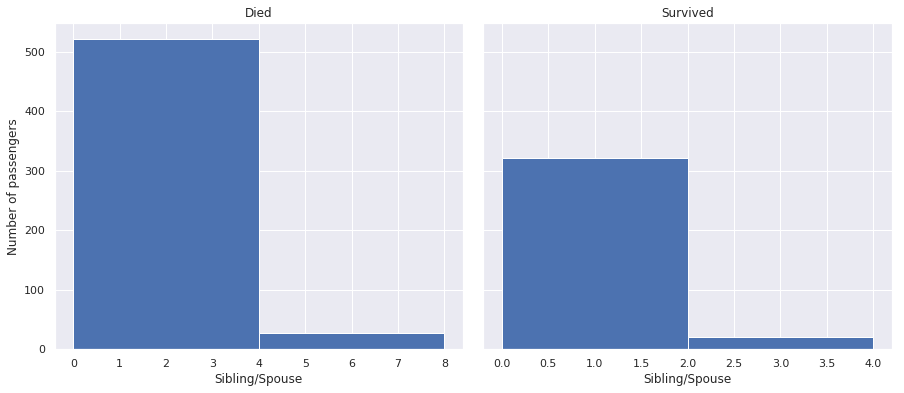

In [19]:
fig, ax = plt.subplots(1, 2, sharey='row', figsize=(15, 6))
fig.subplots_adjust(wspace=0.05)

ax[0].set_title('Died')
ax[0].set_xlabel('Sibling/Spouse')
ax[0].set_ylabel('Number of passengers')
df_train[df_train['Survived'] == 0]['SibSp'].hist(bins=2, ax=ax[0])

ax[1].set_title('Survived')
ax[1].set_xlabel('Sibling/Spouse')
df_train[df_train['Survived'] == 1]['SibSp'].hist(bins=2, ax=ax[1])

### Parents/Children

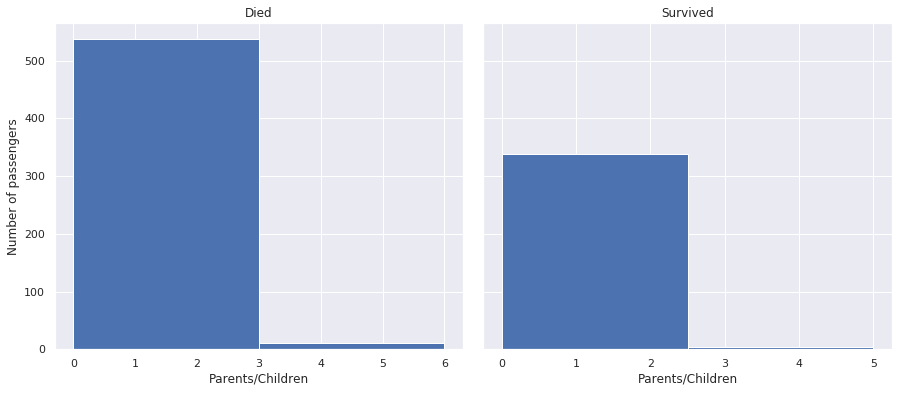

In [20]:
fig, ax = plt.subplots(1, 2, sharey='row', figsize=(15, 6))
fig.subplots_adjust(wspace=0.05)

ax[0].set_title('Died')
ax[0].set_xlabel('Parents/Children')
ax[0].set_ylabel('Number of passengers')
df_train[df_train['Survived'] == 0]['Parch'].hist(bins=2, ax=ax[0])

ax[1].set_title('Survived')
ax[1].set_xlabel('Parents/Children')
df_train[df_train['Survived'] == 1]['Parch'].hist(bins=2, ax=ax[1])

## Feature engineering

In [5]:
df_train['Age'].fillna(df_train['Age'].median(), inplace=True)
df_test['Age'].fillna(df_test['Age'].median(), inplace=True)

In [6]:
df_train['Sex'] = df_train['Sex'].map({'male': 0, 'female': 1})
df_test['Sex'] = df_test['Sex'].map({'male': 0, 'female': 1})

In [7]:
df_train['has_cabin'] = np.where(df_train['Cabin'].isna(), 0, 1)
df_test['has_cabin'] = np.where(df_test['Cabin'].isna(), 0, 1)

In [8]:
df_train['FamilySize'] = df_train['SibSp'] + df_train['Parch'] + 1
df_test['FamilySize'] = df_test['SibSp'] + df_test['Parch'] + 1

df_train['IsAlone'] = 1
df_test['IsAlone'] = 1
df_train['IsAlone'].loc[df_train['FamilySize'] > 1] = 0
df_test['IsAlone'].loc[df_test['FamilySize'] > 1] = 0

df_train['Title'] = df_train['Name'].str.split(", ", expand=True)[1].str.split(".", expand=True)[0]
df_test['Title'] = df_test['Name'].str.split(", ", expand=True)[1].str.split(".", expand=True)[0]

df_train['FareBin'] = pd.qcut(df_train['Fare'], 4)
df_test['FareBin'] = pd.qcut(df_test['Fare'], 4)

df_train['AgeBin'] = pd.cut(df_train['Age'].astype(int), 5)
df_test['AgeBin'] = pd.cut(df_test['Age'].astype(int), 5)

stat_min = 10
title_names_train = (df_train['Title'].value_counts() < stat_min)
title_names_test = (df_test['Title'].value_counts() < stat_min)

df_train['Title'] = df_train['Title'].apply(lambda x: 'Misc' if title_names_train.loc[x] == True else x)
df_test['Title'] = df_test['Title'].apply(lambda x: 'Misc' if title_names_test.loc[x] == True else x)
print(df_train['Title'].value_counts())
print(df_test['Title'].value_counts())

Mr        517
Miss      182
Mrs       125
Master     40
Misc       27
Name: Title, dtype: int64
Mr        240
Miss       78
Mrs        72
Master     21
Misc        7
Name: Title, dtype: int64


In [9]:
df_train['Fare'].fillna(df_train['Fare'].median(), inplace=True)

In [10]:
df_train[df_train['Embarked'].isna()]

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,has_cabin,FamilySize,IsAlone,Title,FareBin,AgeBin
PassengerId,,,,,,,,,,,,,,,,
62,1,1,"Icard, Miss. Amelie",1,38.0,0,0,80.0,B28,NaN,1,1,1,Miss,"(31.0, 512.5]","(32.0, 48.0]"
830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",1,62.0,0,0,80.0,B28,NaN,1,1,1,Mrs,"(31.0, 512.5]","(48.0, 64.0]"


In [11]:
df_train.at[62, 'Embarked'] = 'S'
df_train.at[830, 'Embarked'] = 'S'

In [12]:
len(df_train[df_train['Embarked'].isna()])

0

In [13]:
le = preprocessing.LabelEncoder()

# Embarked
le.fit(df_train['Embarked'])
df_train['Embarked'] = le.transform(df_train['Embarked'])

le.fit(df_test['Embarked'])
df_test['Embarked'] = le.transform(df_test['Embarked'])

# Title
le.fit(df_train['Title'])
df_train['Title'] = le.transform(df_train['Title'])

le.fit(df_test['Title'])
df_test['Title'] = le.transform(df_test['Title'])

In [14]:
df_train = reduce_memory_usage(df_train)
df_test = reduce_memory_usage(df_test)

Starting memory usage:  0.10 MB
Reduced memory usage:  0.07 MB (28.9% reduction)
Starting memory usage:  0.03 MB
Reduced memory usage:  0.02 MB (47.1% reduction)


In [15]:
df_train.isna().sum()

Survived        0
Pclass          0
Name            0
Sex             0
Age             0
SibSp           0
Parch           0
Fare            0
Cabin         687
Embarked        0
has_cabin       0
FamilySize      0
IsAlone         0
Title           0
FareBin         0
AgeBin          0
dtype: int64

In [16]:
df_test.isna().sum()

Pclass          0
Name            0
Sex             0
Age             0
SibSp           0
Parch           0
Fare            1
Cabin         327
Embarked        0
has_cabin       0
FamilySize      0
IsAlone         0
Title           0
FareBin         1
AgeBin          0
dtype: int64

## Dimension reduction

In [33]:
df_train['Age'].fillna(df_train['Age'].mean(), inplace=True)
df_test['Age'].fillna(df_test['Age'].mean(), inplace=True)

### PCA

In [34]:
features = df_train.select_dtypes(include=['int8', 'int64', 'float16', 'float64']).columns

In [35]:
features

Index(['Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare',
       'Embarked', 'has_cabin', 'FamilySize', 'IsAlone', 'Title'],
      dtype='object')

In [36]:
df_train.isna().sum()

Survived        0
Pclass          0
Name            0
Sex             0
Age             0
SibSp           0
Parch           0
Fare            0
Cabin         687
Embarked        0
has_cabin       0
FamilySize      0
IsAlone         0
Title           0
FareBin         0
AgeBin          0
dtype: int64

In [37]:
pca = PCA(n_components=2)
pca_result = pca.fit_transform(df_train[features].values)

df_train['pca_1'] = pca_result[:,0]
df_train['pca_2'] = pca_result[:,1]

print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

Explained variation per principal component: [0.93397016 0.06358084]


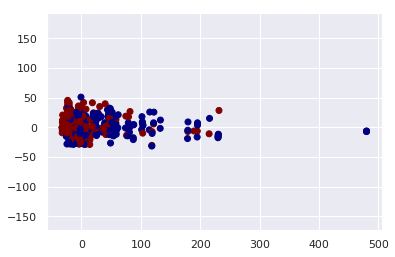

In [38]:
plt.scatter(df_train['pca_1'], df_train['pca_2'], c=df_train['Survived'], cmap="jet_r")
plt.axis('equal');

In [39]:
del df_train['pca_1'], df_train['pca_2']

### t-SNE

In [40]:
n_sne = 3000

tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(df_train.loc[:, features].values)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 891 samples in 0.002s...
[t-SNE] Computed neighbors for 891 samples in 0.031s...
[t-SNE] Computed conditional probabilities for sample 891 / 891
[t-SNE] Mean sigma: 1.706064
[t-SNE] KL divergence after 250 iterations with early exaggeration: 52.785221
[t-SNE] KL divergence after 300 iterations: 0.351870


In [41]:
df_tsne = df_train.copy()
df_tsne['x-tsne'] = tsne_results[:,0]
df_tsne['y-tsne'] = tsne_results[:,1]

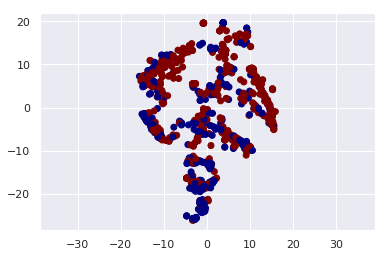

In [42]:
plt.scatter(df_tsne['x-tsne'], df_tsne['y-tsne'], c=df_tsne['Survived'], cmap="jet_r")
plt.axis('equal');

## Training
### Decision trees

In [17]:
df_train_columns = [c for c in df_train.columns if c not in ['PassangerId', 'Survived', 'Cabin', 'Name', 'FareBin', 'AgeBin']]
target = df_train['Survived']
del df_train['Survived']

#### LightGBM

In [44]:
df_train[:3]

,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,has_cabin,FamilySize,IsAlone,Title,FareBin,AgeBin
PassengerId,,,,,,,,,,,,,,,
1,3,"Braund, Mr. Owen Harris",0,22.0,1,0,7.250000,NaN,2,0,2,0,3,"(-0.001, 7.91]","(16.0, 32.0]"
2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,71.312500,C85,0,1,2,0,4,"(31.0, 512.5]","(32.0, 48.0]"
3,3,"Heikkinen, Miss. Laina",1,26.0,0,0,7.925781,NaN,2,0,1,1,2,"(7.91, 14.453]","(16.0, 32.0]"


In [45]:
%%time
params_lgb = {
    "bagging_freq": 1,
    "bagging_fraction": 0.9,
    "bagging_seed": 1,
    "boosting": "gbdt",

    "feature_fraction": 0.9,
    "feature_fraction_seed": 1,

    "lambda_l1": 0.1,
    "learning_rate": 0.01,

    'max_depth': -1,
    "metric": "rmse",
    "num_leaves": 31,
    "nthread": -1,

    "objective": "binary",

    "random_state": 1,
    "verbosity": -1
}

folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
oof_lgb = np.zeros(len(df_train))
pred_test_lgb = np.zeros(len(df_test))
feature_importance_lgb = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(df_train, df_train['Pclass'].values)):
    print("\nFold {}.".format(fold_+1))
    trn_data = lgb.Dataset(df_train.iloc[trn_idx][df_train_columns], label=target.iloc[trn_idx])
    val_data = lgb.Dataset(df_train.iloc[val_idx][df_train_columns], label=target.iloc[val_idx])

    num_round = 10000
    model_lgb = lgb.train(params_lgb, trn_data, num_round, valid_sets = [trn_data, val_data], categorical_feature=['Embarked', 'Pclass'] , verbose_eval=100, early_stopping_rounds=100)
    oof_lgb[val_idx] = model_lgb.predict(df_train.iloc[val_idx][df_train_columns], num_iteration=model_lgb.best_iteration)
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = df_train_columns
    fold_importance_df["importance"] = model_lgb.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_lgb = pd.concat([feature_importance_lgb, fold_importance_df], axis=0)
    
    pred_test_lgb += model_lgb.predict(df_test[df_train_columns], num_iteration=model_lgb.best_iteration) / folds.n_splits


Fold 1.
Training until validation scores don't improve for 100 rounds.
[100]	training's rmse: 0.358197	valid_1's rmse: 0.391183
[200]	training's rmse: 0.319761	valid_1's rmse: 0.368946
[300]	training's rmse: 0.298819	valid_1's rmse: 0.364581
[400]	training's rmse: 0.281176	valid_1's rmse: 0.364603
Early stopping, best iteration is:
[369]	training's rmse: 0.286301	valid_1's rmse: 0.363765

Fold 2.
Training until validation scores don't improve for 100 rounds.
[100]	training's rmse: 0.358373	valid_1's rmse: 0.390932
[200]	training's rmse: 0.320419	valid_1's rmse: 0.371139
[300]	training's rmse: 0.300919	valid_1's rmse: 0.367874
Early stopping, best iteration is:
[288]	training's rmse: 0.302996	valid_1's rmse: 0.367655

Fold 3.
Training until validation scores don't improve for 100 rounds.
[100]	training's rmse: 0.362839	valid_1's rmse: 0.38607
[200]	training's rmse: 0.32672	valid_1's rmse: 0.36035
[300]	training's rmse: 0.307299	valid_1's rmse: 0.352595
[400]	training's rmse: 0.290559	v

In [46]:
pred_train_lgb = model_lgb.predict(df_train[df_train_columns])
pred_train_lgb = np.where(pred_train_lgb > 0.5, 1, 0)

In [47]:
cv_score_lgb = np.sqrt(mean_squared_error(oof_lgb, target))
print("CV score: {:.6f}".format(cv_score_lgb))

auc_score_lgb = roc_auc_score(target, pred_train_lgb)
print('Area under curve: {:.4f}%'.format(auc_score_lgb*100))

CV score: 0.353662
Area under curve: 85.7372%


In [48]:
confusion_matrix(target, pred_train_lgb)

array([[516,  33],
       [ 77, 265]])

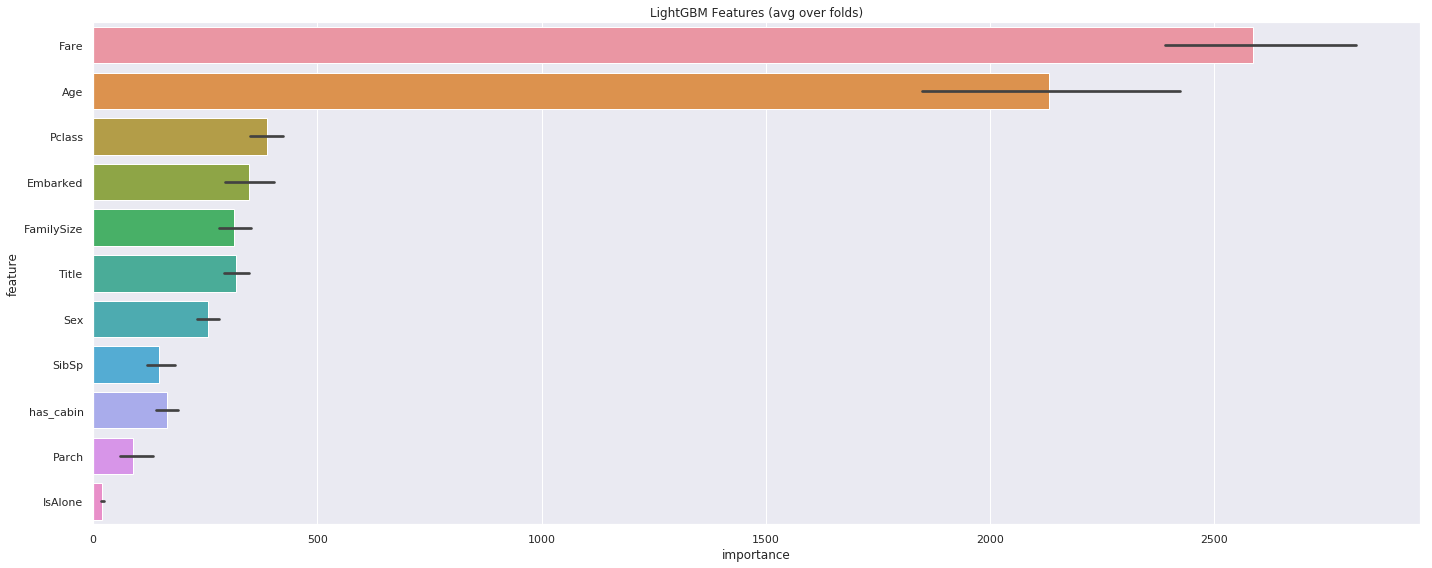

In [49]:
cols = (feature_importance_lgb[["feature", "importance"]]
        .groupby("feature")
        .mean()
        .sort_values(by="importance", ascending=False).index)

best_features_lgb = feature_importance_lgb.loc[feature_importance_lgb.feature.isin(cols)]

plt.figure(figsize=(20, 8))
sns.barplot(x="importance", y="feature", data=best_features_lgb.sort_values(by="importance", ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.savefig('lgbm_importances.png')

[Receiver Operating Characteristic](https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html)

In [50]:
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(len(target)):
    fpr[i], tpr[i], _ = roc_curve(target, pred_train_lgb)
    roc_auc[i] = auc(fpr[i], tpr[i])

fpr["micro"], tpr["micro"], _ = roc_curve(target.ravel(), pred_train_lgb.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

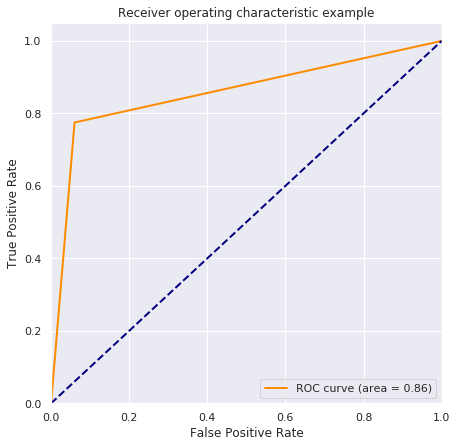

In [51]:
plt.figure(figsize=(7, 7))
lw = 2
plt.plot(fpr[2], tpr[2], color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[2])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [52]:
sub_df = pd.DataFrame({
    "PassengerId": df_test.index.values
})

sub_df["Survived"] = np.where(pred_test_lgb > 0.5, 1, 0)
sub_df.to_csv("output/regression_{:.6f}.csv".format(auc_score_lgb), index=False)
print("´output/regression_{:.6f}.csv´ saved".format(auc_score_lgb))

´output/regression_0.857372.csv´ saved


In [ ]:
print('CV score: {:.5f}\nLB score: {:.5f}'.format(cv_score_lgb, 0.75119))

#### XGBoost

In [53]:
%%time
params_xgb = {
    'colsample_bytree': 0.8,
    'eta': 0.05,
    'eval_metric': 'rmse',
    'max_depth': 20,
    'objective': 'binary:hinge',
    'random_state': 1,
    'silent': True,
    'subsample': 0.8
}

folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=402)
oof_xgb = np.zeros(len(df_train))
pred_test_xgb = np.zeros(len(df_test))
feature_importance_xgb = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(df_train, df_train['Pclass'].values)):
    print("\nFold {}.".format(fold_+1))
    trn_data = xgb.DMatrix(data=df_train.iloc[trn_idx][df_train_columns], label=target.iloc[trn_idx])
    val_data = xgb.DMatrix(data=df_train.iloc[val_idx][df_train_columns], label=target.iloc[val_idx])
    watchlist = [(trn_data, 'train'), (val_data, 'valid')]

    num_round = 10000
    model_xgb = xgb.train(params_xgb, trn_data, num_round, watchlist, early_stopping_rounds=50, verbose_eval=1000)
    oof_xgb[val_idx] = model_xgb.predict(xgb.DMatrix(df_train.iloc[val_idx][df_train_columns]), ntree_limit=model_xgb.best_ntree_limit+50)
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = df_train_columns
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_lxgb = pd.concat([feature_importance_xgb, fold_importance_df], axis=0)
    
    pred_test_xgb += model_xgb.predict(xgb.DMatrix(df_test[df_train_columns]), ntree_limit=model_xgb.best_ntree_limit+50) / folds.n_splits


Fold 1.
[0]	train-rmse:0.787562	valid-rmse:0.774597
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
Stopping. Best iteration:
[28]	train-rmse:0.205412	valid-rmse:0.434613


Fold 2.
[0]	train-rmse:0.781088	valid-rmse:0.800281
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
Stopping. Best iteration:
[76]	train-rmse:0.149801	valid-rmse:0.374766


Fold 3.
[0]	train-rmse:0.77929	valid-rmse:0.80727
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
Stopping. Best iteration:
[29]	train-rmse:0.242706	valid-rmse:0.389468


Fold 4.
[0]	train-rmse:0.790902	valid-rmse:0.760692
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 ro

In [54]:
pred_train_xgb = model_xgb.predict(xgb.DMatrix(df_train[df_train_columns]))

In [55]:
cv_score_xgb = np.sqrt(mean_squared_error(oof_xgb, target))
print("CV score: {:.6f}".format(cv_score_xgb))

auc_score_xgb = roc_auc_score(target, pred_train_xgb)
print('Area under curve: {:.4f}%'.format(auc_score_xgb*100))

CV score: 0.414388
Area under curve: 95.1419%


In [56]:
confusion_matrix(target, pred_train_xgb)

array([[539,  10],
       [ 27, 315]])

#### CatBoost

In [57]:
category_columns = df_train[df_train_columns].select_dtypes(include=['int8', 'int16', 'int32', 'int64']).columns.tolist()

In [58]:
category_columns_index = []

for i in category_columns:
    category_columns_index.append(df_train[df_train_columns].columns.get_loc(i))
    print(str(df_train[df_train_columns].columns.get_loc(i)) + ': ' + i)

0: Pclass
1: Sex
3: SibSp
4: Parch
6: Embarked
7: has_cabin
8: FamilySize
9: IsAlone
10: Title


In [59]:
%%time
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
oof_cat = np.zeros(len(df_train))
pred_test_cat = np.zeros(len(df_test))
feature_importance_cat = pd.DataFrame()

model_cat = CatBoostRegressor(
    iterations=1000,
    learning_rate=0.05,
    depth=6,
    eval_metric='RMSE',
    bagging_temperature = 0.9,
    od_type='Iter',
    #metric_period = 100,
    od_wait=50
)

for fold_, (trn_idx, val_idx) in enumerate(folds.split(df_train, df_train['Pclass'].values)):
    print("\nFold {}.".format(fold_+1))
    trn_data = df_train.iloc[trn_idx][df_train_columns]
    trn_label = target.iloc[trn_idx]
    val_data = df_train.iloc[val_idx][df_train_columns]
    val_label = target.iloc[val_idx]

    num_round = 10000
    model_cat.fit(trn_data, trn_label, eval_set=(val_data, val_label), cat_features=category_columns_index, use_best_model=True, verbose=100)
    
    oof_cat[val_idx] = model_cat.predict(df_train.iloc[val_idx][df_train_columns])
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = df_train_columns
    fold_importance_df["importance"] = model_cat.feature_importances_
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_cat = pd.concat([feature_importance_cat, fold_importance_df], axis=0)
    
    pred_test_cat += model_cat.predict(df_test[df_train_columns].fillna(0)) / folds.n_splits


Fold 1.
0:	learn: 0.5991950	test: 0.6114336	best: 0.6114336 (0)	total: 71.6ms	remaining: 1m 11s
100:	learn: 0.3404216	test: 0.3754492	best: 0.3754492 (100)	total: 462ms	remaining: 4.11s
200:	learn: 0.3222025	test: 0.3695774	best: 0.3695774 (200)	total: 881ms	remaining: 3.5s
300:	learn: 0.3099924	test: 0.3670147	best: 0.3668894 (280)	total: 1.43s	remaining: 3.33s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.3659549613
bestIteration = 316

Shrink model to first 317 iterations.

Fold 2.
0:	learn: 0.5940925	test: 0.6356767	best: 0.6356767 (0)	total: 3.65ms	remaining: 3.65s
100:	learn: 0.3473277	test: 0.3628573	best: 0.3628573 (100)	total: 316ms	remaining: 2.81s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.3589396945
bestIteration = 134

Shrink model to first 135 iterations.

Fold 3.
0:	learn: 0.5989564	test: 0.6138591	best: 0.6138591 (0)	total: 3.6ms	remaining: 3.6s
100:	learn: 0.3510540	test: 0.3806012	best: 0.3805860 (97)	total: 326ms	remain

In [60]:
pred_train_cat = model_cat.predict(df_train[df_train_columns])
pred_train_cat = np.where(pred_train_cat > 0.5, 1, 0)

In [61]:
cv_score_cat = np.sqrt(mean_squared_error(oof_cat, target))
print("CV score: {:.6f}".format(cv_score_cat))

auc_score_cat = roc_auc_score(target, pred_train_cat)
print('Area under curve: {:.4f}%'.format(auc_score_cat*100))

CV score: 0.354510
Area under curve: 80.5172%


In [62]:
confusion_matrix(target, pred_train_cat)

array([[494,  55],
       [ 99, 243]])

#### Meta model

In [63]:
train_stack = np.vstack([oof_lgb, oof_xgb, oof_cat]).transpose()
test_stack = np.vstack([pred_test_lgb, pred_test_xgb, pred_test_cat]).transpose()

folds = KFold(n_splits=5, shuffle=True, random_state=1)
oof_stack = np.zeros(train_stack.shape[0])
pred_test_stack = np.zeros(test_stack.shape[0])

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train_stack, target)):
    print("\nFold {}.".format(fold_+1))
    trn_data, trn_y = train_stack[trn_idx], target.iloc[trn_idx].values
    val_data, val_y = train_stack[val_idx], target.iloc[val_idx].values

    model_ridge = Ridge(alpha=100)
    model_ridge.fit(trn_data, trn_y)
    
    oof_stack[val_idx] = model_ridge.predict(val_data)
    pred_test_stack += model_ridge.predict(test_stack) / 5


Fold 1.

Fold 2.

Fold 3.

Fold 4.

Fold 5.


In [64]:
cv_score_stack = np.sqrt(mean_squared_error(oof_stack, target))
print("CV score: {:.6f}".format(cv_score_stack))

CV score: 0.360241


In [65]:
sub_df = pd.DataFrame({
    "PassengerId": df_test.index.values
})

sub_df["Survived"] = np.where(pred_test_stack > 0.5, 1, 0)
sub_df.to_csv("output/stacking_{:.6f}.csv".format(cv_score_stack), index=False)
print("´output/stacking_{:.6f}.csv´ saved".format(cv_score_stack))

´output/stacking_0.360241.csv´ saved


In [67]:
print('CV score: {:.5f}\nLB score: {:.5f}'.format(cv_score_stack, 0.76076))

CV score: 0.36024
LB score: 0.76076


### Machine Learning Algorithms
Inspired by [A Data Science Framework: To Achieve 99% Accuracy](https://www.kaggle.com/ldfreeman3/a-data-science-framework-to-achieve-99-accuracy)

In [18]:
MLA = [
    #Ensemble Methods
    ensemble.AdaBoostClassifier(),
    ensemble.BaggingClassifier(),
    ensemble.ExtraTreesClassifier(),
    ensemble.GradientBoostingClassifier(),
    ensemble.RandomForestClassifier(),

    #Gaussian Processes
    gaussian_process.GaussianProcessClassifier(),

    #GLM
    linear_model.LogisticRegressionCV(),
    linear_model.PassiveAggressiveClassifier(),
    linear_model.RidgeClassifierCV(),
    linear_model.SGDClassifier(),
    linear_model.Perceptron(),

    #Navies Bayes
    naive_bayes.BernoulliNB(),
    naive_bayes.GaussianNB(),

    #Nearest Neighbor
    neighbors.KNeighborsClassifier(),

    #SVM
    svm.SVC(probability=True),
    svm.NuSVC(probability=True),
    svm.LinearSVC(),

    #Trees
    tree.DecisionTreeClassifier(),
    tree.ExtraTreeClassifier(),

    #Discriminant Analysis
    discriminant_analysis.LinearDiscriminantAnalysis(),
    #discriminant_analysis.QuadraticDiscriminantAnalysis(),
    
    XGBClassifier()
]

#split dataset in cross-validation with this splitter class: http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.ShuffleSplit.html#sklearn.model_selection.ShuffleSplit
#note: this is an alternative to train_test_split
cv_split = model_selection.ShuffleSplit(n_splits = 10, test_size = .3, train_size = .6, random_state = 0 ) # run model 10x with 60/30 split intentionally leaving out 10%

#create table to compare MLA metrics
MLA_columns = ['MLA Name', 'MLA Parameters','MLA Train Accuracy Mean', 'MLA Test Accuracy Mean', 'MLA Test Accuracy 3*STD' ,'MLA Time']
MLA_compare = pd.DataFrame(columns = MLA_columns)

#create table to compare MLA predictions
MLA_predict = df_train[df_train_columns]

#index through MLA and save performance to table
row_index = 0
for alg in MLA:

    #set name and parameters
    MLA_name = alg.__class__.__name__
    MLA_compare.loc[row_index, 'MLA Name'] = MLA_name
    MLA_compare.loc[row_index, 'MLA Parameters'] = str(alg.get_params())
    
    #score model with cross validation: http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html#sklearn.model_selection.cross_validate
    cv_results = model_selection.cross_validate(alg, df_train[df_train_columns], target, cv  = cv_split)

    MLA_compare.loc[row_index, 'MLA Time'] = cv_results['fit_time'].mean()
    MLA_compare.loc[row_index, 'MLA Train Accuracy Mean'] = cv_results['train_score'].mean()
    MLA_compare.loc[row_index, 'MLA Test Accuracy Mean'] = cv_results['test_score'].mean()   
    #if this is a non-bias random sample, then +/-3 standard deviations (std) from the mean, should statistically capture 99.7% of the subsets
    MLA_compare.loc[row_index, 'MLA Test Accuracy 3*STD'] = cv_results['test_score'].std()*3   #let's know the worst that can happen!

    #save MLA predictions - see section 6 for usage
    alg.fit(df_train[df_train_columns], target)
    MLA_predict[MLA_name] = alg.predict(df_train[df_train_columns])

    row_index+=1
    
#print and sort table: https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.sort_values.html
MLA_compare.sort_values(by = ['MLA Test Accuracy Mean'], ascending = False, inplace = True)

In [19]:
MLA_compare

,MLA Name,MLA Parameters,MLA Train Accuracy Mean,MLA Test Accuracy Mean,MLA Test Accuracy 3*STD,MLA Time
3,GradientBoostingClassifier,"{'criterion': 'friedman_mse', 'init': None, 'l...",0.917603,0.836567,0.058766,0.0674631
20,XGBClassifier,"{'base_score': 0.5, 'booster': 'gbtree', 'cols...",0.894944,0.833209,0.0684668,0.0353651
0,AdaBoostClassifier,"{'algorithm': 'SAMME.R', 'base_estimator': Non...",0.850749,0.814925,0.0629658,0.0564868
4,RandomForestClassifier,"{'bootstrap': True, 'class_weight': None, 'cri...",0.97191,0.811194,0.0643438,0.0117211
6,LogisticRegressionCV,"{'Cs': 10, 'class_weight': None, 'cv': 'warn',...",0.814607,0.808582,0.0581767,0.357499
8,RidgeClassifierCV,"{'alphas': array([ 0.1, 1. , 10. ]), 'class_w...",0.811423,0.801119,0.0445095,0.00830157
1,BaggingClassifier,"{'base_estimator': None, 'bootstrap': True, 'b...",0.971348,0.800746,0.0416442,0.0165063
19,LinearDiscriminantAnalysis,"{'n_components': None, 'priors': None, 'shrink...",0.810112,0.8,0.0445517,0.00360346
2,ExtraTreesClassifier,"{'bootstrap': False, 'class_weight': None, 'cr...",0.988577,0.797388,0.0566489,0.0114278
17,DecisionTreeClassifier,"{'class_weight': None, 'criterion': 'gini', 'm...",0.988577,0.78097,0.0664232,0.00567245


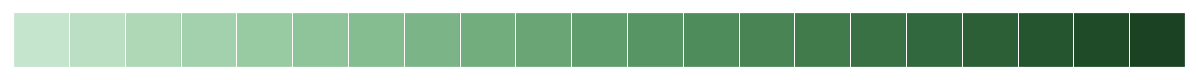

In [44]:
sns.palplot(sns.cubehelix_palette(len(MLA_compare), start=2, rot=0, dark=0.2, light=.85, reverse=False))

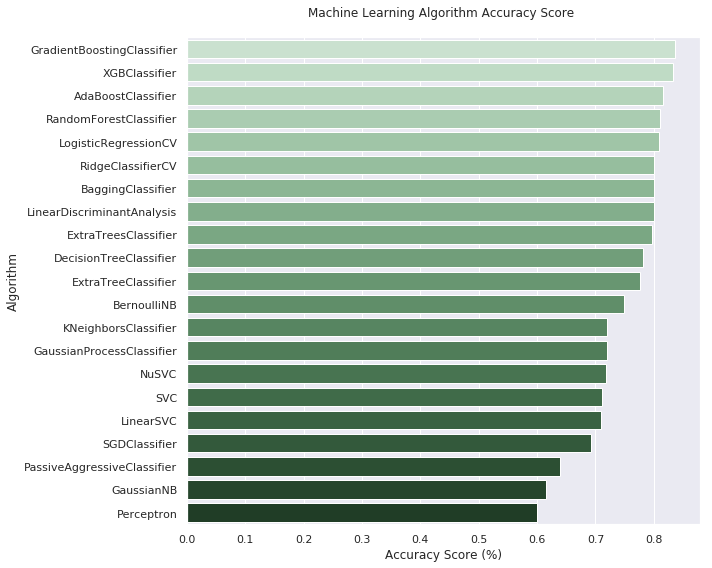

In [46]:
plt.figure(figsize=(10, 8))
sns.barplot(x='MLA Test Accuracy Mean', y = 'MLA Name', data = MLA_compare, palette=sns.cubehelix_palette(len(MLA_compare), start=2, rot=0, dark=0.2, light=.85, reverse=False))

plt.title('Machine Learning Algorithm Accuracy Score \n')
plt.xlabel('Accuracy Score (%)')
plt.ylabel('Algorithm')
plt.tight_layout()

#### GridSearch

In [48]:
dtree = tree.DecisionTreeClassifier(random_state = 0)
base_results = model_selection.cross_validate(dtree, df_train[df_train_columns], target, cv  = cv_split)
dtree.fit(df_train[df_train_columns], target)

print('BEFORE DT Parameters: ', dtree.get_params())
print("BEFORE DT Training w/bin score mean: {:.2f}". format(base_results['train_score'].mean()*100)) 
print("BEFORE DT Test w/bin score mean: {:.2f}". format(base_results['test_score'].mean()*100))
print("BEFORE DT Test w/bin score 3*std: +/- {:.2f}". format(base_results['test_score'].std()*100*3))
print('-'*10)

param_grid = {
    'criterion': ['gini', 'entropy'],  #scoring methodology; two supported formulas for calculating information gain - default is gini
    'max_depth': [2, 4, 6, 8, 10, None], #max depth tree can grow; default is none
    'random_state': [0] #seed or control random number generator: https://www.quora.com/What-is-seed-in-random-number-generation
}

tune_model = model_selection.GridSearchCV(tree.DecisionTreeClassifier(), param_grid=param_grid, scoring = 'roc_auc', cv = cv_split)
tune_model.fit(df_train[df_train_columns], target)

print('AFTER DT Parameters: ', tune_model.best_params_)
print("AFTER DT Training w/bin score mean: {:.2f}". format(tune_model.cv_results_['mean_train_score'][tune_model.best_index_]*100)) 
print("AFTER DT Test w/bin score mean: {:.2f}". format(tune_model.cv_results_['mean_test_score'][tune_model.best_index_]*100))
print("AFTER DT Test w/bin score 3*std: +/- {:.2f}". format(tune_model.cv_results_['std_test_score'][tune_model.best_index_]*100*3))

BEFORE DT Parameters:  {'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'presort': False, 'random_state': 0, 'splitter': 'best'}
BEFORE DT Training w/bin score mean: 98.86
BEFORE DT Test w/bin score mean: 77.76
BEFORE DT Test w/bin score 3*std: +/- 5.62
----------
AFTER DT Parameters:  {'criterion': 'gini', 'max_depth': 4, 'random_state': 0}
AFTER DT Training w/bin score mean: 89.69
AFTER DT Test w/bin score mean: 84.67
AFTER DT Test w/bin score 3*std: +/- 8.46


#### Feature selection

In [51]:
print('BEFORE DT RFE Training Shape Old: ', df_train[df_train_columns].shape) 
print('BEFORE DT RFE Training Columns Old: ', df_train[df_train_columns].columns.values)

print("BEFORE DT RFE Training w/bin score mean: {:.2f}". format(base_results['train_score'].mean()*100)) 
print("BEFORE DT RFE Test w/bin score mean: {:.2f}". format(base_results['test_score'].mean()*100))
print("BEFORE DT RFE Test w/bin score 3*std: +/- {:.2f}". format(base_results['test_score'].std()*100*3))
print('-'*10)

#feature selection
dtree_rfe = feature_selection.RFECV(dtree, step = 1, scoring = 'accuracy', cv = cv_split)
dtree_rfe.fit(df_train[df_train_columns], target)

#transform x&y to reduced features and fit new model
#alternative: can use pipeline to reduce fit and transform steps: http://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html
X_rfe = df_train[df_train_columns].columns.values[dtree_rfe.get_support()]
rfe_results = model_selection.cross_validate(dtree, df_train[X_rfe], target, cv  = cv_split)

#print(dtree_rfe.grid_scores_)
print('AFTER DT RFE Training Shape New: ', df_train[X_rfe].shape) 
print('AFTER DT RFE Training Columns New: ', X_rfe)

print("AFTER DT RFE Training w/bin score mean: {:.2f}". format(rfe_results['train_score'].mean()*100)) 
print("AFTER DT RFE Test w/bin score mean: {:.2f}". format(rfe_results['test_score'].mean()*100))
print("AFTER DT RFE Test w/bin score 3*std: +/- {:.2f}". format(rfe_results['test_score'].std()*100*3))
print('-'*10)

#tune rfe model
rfe_tune_model = model_selection.GridSearchCV(tree.DecisionTreeClassifier(), param_grid=param_grid, scoring = 'roc_auc', cv = cv_split)
rfe_tune_model.fit(df_train[X_rfe], target)

#print(rfe_tune_model.cv_results_.keys())
#print(rfe_tune_model.cv_results_['params'])
print('AFTER DT RFE Tuned Parameters: ', rfe_tune_model.best_params_)
#print(rfe_tune_model.cv_results_['mean_train_score'])
print("AFTER DT RFE Tuned Training w/bin score mean: {:.2f}". format(rfe_tune_model.cv_results_['mean_train_score'][tune_model.best_index_]*100)) 
#print(rfe_tune_model.cv_results_['mean_test_score'])
print("AFTER DT RFE Tuned Test w/bin score mean: {:.2f}". format(rfe_tune_model.cv_results_['mean_test_score'][tune_model.best_index_]*100))
print("AFTER DT RFE Tuned Test w/bin score 3*std: +/- {:.2f}". format(rfe_tune_model.cv_results_['std_test_score'][tune_model.best_index_]*100*3))

BEFORE DT RFE Training Shape Old:  (891, 11)
BEFORE DT RFE Training Columns Old:  ['Pclass' 'Sex' 'Age' 'SibSp' 'Parch' 'Fare' 'Embarked' 'has_cabin'
 'FamilySize' 'IsAlone' 'Title']
BEFORE DT RFE Training w/bin score mean: 98.86
BEFORE DT RFE Test w/bin score mean: 77.76
BEFORE DT RFE Test w/bin score 3*std: +/- 5.62
----------
AFTER DT RFE Training Shape New:  (891, 6)
AFTER DT RFE Training Columns New:  ['Pclass' 'Sex' 'Age' 'Fare' 'has_cabin' 'FamilySize']
AFTER DT RFE Training w/bin score mean: 98.75
AFTER DT RFE Test w/bin score mean: 78.84
AFTER DT RFE Test w/bin score 3*std: +/- 7.20
----------
AFTER DT RFE Tuned Parameters:  {'criterion': 'gini', 'max_depth': 4, 'random_state': 0}
AFTER DT RFE Tuned Training w/bin score mean: 89.43
AFTER DT RFE Tuned Test w/bin score mean: 84.21
AFTER DT RFE Tuned Test w/bin score 3*std: +/- 7.68
----------


In [55]:
vote_est = [
    #Ensemble Methods: http://scikit-learn.org/stable/modules/ensemble.html
    ('ada', ensemble.AdaBoostClassifier()),
    ('bc', ensemble.BaggingClassifier()),
    ('etc',ensemble.ExtraTreesClassifier()),
    ('gbc', ensemble.GradientBoostingClassifier()),
    ('rfc', ensemble.RandomForestClassifier()),

    #Gaussian Processes: http://scikit-learn.org/stable/modules/gaussian_process.html#gaussian-process-classification-gpc
    ('gpc', gaussian_process.GaussianProcessClassifier()),
    
    #GLM: http://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
    ('lr', linear_model.LogisticRegressionCV()),
    
    #Navies Bayes: http://scikit-learn.org/stable/modules/naive_bayes.html
    ('bnb', naive_bayes.BernoulliNB()),
    ('gnb', naive_bayes.GaussianNB()),
    
    #Nearest Neighbor: http://scikit-learn.org/stable/modules/neighbors.html
    ('knn', neighbors.KNeighborsClassifier()),
    
    #SVM: http://scikit-learn.org/stable/modules/svm.html
    ('svc', svm.SVC(probability=True)),
    
    #xgboost: http://xgboost.readthedocs.io/en/latest/model.html
   ('xgb', XGBClassifier())
]

#Hard Vote or majority rules
vote_hard = ensemble.VotingClassifier(estimators = vote_est , voting = 'hard')
vote_hard_cv = model_selection.cross_validate(vote_hard, df_train[df_train_columns], target, cv  = cv_split)
vote_hard.fit(df_train[df_train_columns], target)

print("Hard Voting Training w/bin score mean: {:.2f}". format(vote_hard_cv['train_score'].mean()*100)) 
print("Hard Voting Test w/bin score mean: {:.2f}". format(vote_hard_cv['test_score'].mean()*100))
print("Hard Voting Test w/bin score 3*std: +/- {:.2f}". format(vote_hard_cv['test_score'].std()*100*3))
print('-'*10)


#Soft Vote or weighted probabilities
vote_soft = ensemble.VotingClassifier(estimators = vote_est , voting = 'soft')
vote_soft_cv = model_selection.cross_validate(vote_soft, df_train[df_train_columns], target, cv  = cv_split)
vote_soft.fit(df_train[df_train_columns], target)

print("Soft Voting Training w/bin score mean: {:.2f}". format(vote_soft_cv['train_score'].mean()*100)) 
print("Soft Voting Test w/bin score mean: {:.2f}". format(vote_soft_cv['test_score'].mean()*100))
print("Soft Voting Test w/bin score 3*std: +/- {:.2f}". format(vote_soft_cv['test_score'].std()*100*3))

Hard Voting Training w/bin score mean: 93.41
Hard Voting Test w/bin score mean: 82.57
Hard Voting Test w/bin score 3*std: +/- 6.92
----------
Soft Voting Training w/bin score mean: 61.52
Soft Voting Test w/bin score mean: 61.49
Soft Voting Test w/bin score 3*std: +/- 4.18


In [ ]:
grid_n_estimator = [50,100,300]
grid_ratio = [.1, .25, .5, .75, 1.0]
grid_learn = [.01, .03, .05, .1, .25]
grid_max_depth = [2, 4, 6, None]
grid_min_samples = [5, 10, .03, .05, .10]
grid_criterion = ['gini', 'entropy']
grid_bool = [True, False]
grid_seed = [0]

vote_param = [{
    #http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html
    'ada__n_estimators': grid_n_estimator,
    'ada__learning_rate': grid_ratio,
    'ada__algorithm': ['SAMME', 'SAMME.R'],
    'ada__random_state': grid_seed,

    #http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html#sklearn.ensemble.BaggingClassifier
    'bc__n_estimators': grid_n_estimator,
    'bc__max_samples': grid_ratio,
    'bc__oob_score': grid_bool, 
    'bc__random_state': grid_seed,

    #http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.ExtraTreesClassifier.html#sklearn.ensemble.ExtraTreesClassifier
    'etc__n_estimators': grid_n_estimator,
    'etc__criterion': grid_criterion,
    'etc__max_depth': grid_max_depth,
    'etc__random_state': grid_seed,


    #http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html#sklearn.ensemble.GradientBoostingClassifier
    'gbc__loss': ['deviance', 'exponential'],
    'gbc__learning_rate': grid_ratio,
    'gbc__n_estimators': grid_n_estimator,
    'gbc__criterion': ['friedman_mse', 'mse', 'mae'],
    'gbc__max_depth': grid_max_depth,
    'gbc__min_samples_split': grid_min_samples,
    'gbc__min_samples_leaf': grid_min_samples,      
    'gbc__random_state': grid_seed,

    #http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn.ensemble.RandomForestClassifier
    'rfc__n_estimators': grid_n_estimator,
    'rfc__criterion': grid_criterion,
    'rfc__max_depth': grid_max_depth,
    'rfc__min_samples_split': grid_min_samples,
    'rfc__min_samples_leaf': grid_min_samples,   
    'rfc__bootstrap': grid_bool,
    'rfc__oob_score': grid_bool, 
    'rfc__random_state': grid_seed,

    #http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegressionCV.html#sklearn.linear_model.LogisticRegressionCV
    'lr__fit_intercept': grid_bool,
    'lr__penalty': ['l1','l2'],
    'lr__solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
    'lr__random_state': grid_seed,

    #http://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.BernoulliNB.html#sklearn.naive_bayes.BernoulliNB
    'bnb__alpha': grid_ratio,
    'bnb__prior': grid_bool,
    'bnb__random_state': grid_seed,

    #http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html#sklearn.neighbors.KNeighborsClassifier
    'knn__n_neighbors': [1,2,3,4,5,6,7],
    'knn__weights': ['uniform', 'distance'],
    'knn__algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'knn__random_state': grid_seed,

    #http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC
    #http://blog.hackerearth.com/simple-tutorial-svm-parameter-tuning-python-r
    'svc__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'svc__C': grid_max_depth,
    'svc__gamma': grid_ratio,
    'svc__decision_function_shape': ['ovo', 'ovr'],
    'svc__probability': [True],
    'svc__random_state': grid_seed,


    #http://xgboost.readthedocs.io/en/latest/parameter.html
    'xgb__learning_rate': grid_ratio,
    'xgb__max_depth': [2,4,6,8,10],
    'xgb__tree_method': ['exact', 'approx', 'hist'],
    'xgb__objective': ['reg:linear', 'reg:logistic', 'binary:logistic'],
    'xgb__seed': grid_seed    

    }]

In [ ]:
grid_n_estimator = [10, 50, 100, 300]
grid_ratio = [.1, .25, .5, .75, 1.0]
grid_learn = [.01, .03, .05, .1, .25]
grid_max_depth = [2, 4, 6, 8, 10, None]
grid_min_samples = [5, 10, .03, .05, .10]
grid_criterion = ['gini', 'entropy']
grid_bool = [True, False]
grid_seed = [0]

grid_param = [
    [{
        #AdaBoostClassifier - http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html
        'n_estimators': grid_n_estimator, #default=50
        'learning_rate': grid_learn, #default=1
        #'algorithm': ['SAMME', 'SAMME.R'], #default=’SAMME.R
        'random_state': grid_seed
    }],
    [{
        #BaggingClassifier - http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html#sklearn.ensemble.BaggingClassifier
        'n_estimators': grid_n_estimator, #default=10
        'max_samples': grid_ratio, #default=1.0
        'random_state': grid_seed
     }],
    [{
        #ExtraTreesClassifier - http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.ExtraTreesClassifier.html#sklearn.ensemble.ExtraTreesClassifier
        'n_estimators': grid_n_estimator, #default=10
        'criterion': grid_criterion, #default=”gini”
        'max_depth': grid_max_depth, #default=None
        'random_state': grid_seed
     }],
    [{
        #GradientBoostingClassifier - http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html#sklearn.ensemble.GradientBoostingClassifier
        #'loss': ['deviance', 'exponential'], #default=’deviance’
        'learning_rate': [.05], #default=0.1 -- 12/31/17 set to reduce runtime -- The best parameter for GradientBoostingClassifier is {'learning_rate': 0.05, 'max_depth': 2, 'n_estimators': 300, 'random_state': 0} with a runtime of 264.45 seconds.
        'n_estimators': [300], #default=100 -- 12/31/17 set to reduce runtime -- The best parameter for GradientBoostingClassifier is {'learning_rate': 0.05, 'max_depth': 2, 'n_estimators': 300, 'random_state': 0} with a runtime of 264.45 seconds.
        #'criterion': ['friedman_mse', 'mse', 'mae'], #default=”friedman_mse”
        'max_depth': grid_max_depth, #default=3   
        'random_state': grid_seed
     }],
    [{
        #RandomForestClassifier - http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn.ensemble.RandomForestClassifier
        'n_estimators': grid_n_estimator, #default=10
        'criterion': grid_criterion, #default=”gini”
        'max_depth': grid_max_depth, #default=None
        'oob_score': [True], #default=False -- 12/31/17 set to reduce runtime -- The best parameter for RandomForestClassifier is {'criterion': 'entropy', 'max_depth': 6, 'n_estimators': 100, 'oob_score': True, 'random_state': 0} with a runtime of 146.35 seconds.
        'random_state': grid_seed
     }],
    #[{    
    #    #GaussianProcessClassifier
    #    'max_iter_predict': grid_n_estimator, #default: 100
    #    'random_state': grid_seed
    #}],
    [{
        #LogisticRegressionCV - http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegressionCV.html#sklearn.linear_model.LogisticRegressionCV
        'fit_intercept': grid_bool, #default: True
        #'penalty': ['l1','l2'],
        'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'], #default: lbfgs
        'random_state': grid_seed
     }],
    #[{
        #BernoulliNB - http://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.BernoulliNB.html#sklearn.naive_bayes.BernoulliNB
    #    'alpha': grid_ratio, #default: 1.0
    # }],
    [{}],
    [{
        #KNeighborsClassifier - http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html#sklearn.neighbors.KNeighborsClassifier
        'n_neighbors': [1,2,3,4,5,6,7], #default: 5
        'weights': ['uniform', 'distance'], #default = ‘uniform’
        'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
    }],
    #GaussianNB - 
    #[{
        #SVC - http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC
        #http://blog.hackerearth.com/simple-tutorial-svm-parameter-tuning-python-r
        #'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
     #   'C': [1,2,3,4,5], #default=1.0
     #   'gamma': grid_ratio, #edfault: auto
     #   'decision_function_shape': ['ovo', 'ovr'], #default:ovr
     #   'probability': [True],
     #   'random_state': grid_seed
     #}],
    [{
        #XGBClassifier - http://xgboost.readthedocs.io/en/latest/parameter.html
        'learning_rate': grid_learn, #default: .3
        'max_depth': [1,2,4,6,8,10], #default 2
        'n_estimators': grid_n_estimator, 
        'seed': grid_seed  
     }]   
]

start_total = time.perf_counter() #https://docs.python.org/3/library/time.html#time.perf_counter
for clf, param in zip (vote_est, grid_param): #https://docs.python.org/3/library/functions.html#zip
    start = time.perf_counter()        
    best_search = model_selection.GridSearchCV(estimator = clf[1], param_grid = param, cv = cv_split, scoring = 'roc_auc')
    best_search.fit(df_train[df_train_columns], target)
    run = time.perf_counter() - start

    best_param = best_search.best_params_
    print('The best parameter for {} is {} with a runtime of {:.2f} seconds.'.format(clf[1].__class__.__name__, best_param, run))
    clf[1].set_params(**best_param) 

run_total = time.perf_counter() - start_total
print('Total optimization time was {:.2f} minutes.'.format(run_total/60))

In [67]:
#Hard Vote or majority rules w/Tuned Hyperparameters
grid_hard = ensemble.VotingClassifier(estimators = vote_est , voting = 'hard')
grid_hard_cv = model_selection.cross_validate(grid_hard, df_train[df_train_columns], target, cv  = cv_split)
grid_hard.fit(df_train[df_train_columns], target)

print("Hard Voting w/Tuned Hyperparameters Training w/bin score mean: {:.2f}". format(grid_hard_cv['train_score'].mean()*100)) 
print("Hard Voting w/Tuned Hyperparameters Test w/bin score mean: {:.2f}". format(grid_hard_cv['test_score'].mean()*100))
print("Hard Voting w/Tuned Hyperparameters Test w/bin score 3*std: +/- {:.2f}". format(grid_hard_cv['test_score'].std()*100*3))
print('-'*10)

#Soft Vote or weighted probabilities w/Tuned Hyperparameters
grid_soft = ensemble.VotingClassifier(estimators = vote_est , voting = 'soft')
grid_soft_cv = model_selection.cross_validate(grid_soft, df_train[df_train_columns], target, cv  = cv_split)
grid_soft.fit(df_train[df_train_columns], target)

print("Soft Voting w/Tuned Hyperparameters Training w/bin score mean: {:.2f}". format(grid_soft_cv['train_score'].mean()*100)) 
print("Soft Voting w/Tuned Hyperparameters Test w/bin score mean: {:.2f}". format(grid_soft_cv['test_score'].mean()*100))
print("Soft Voting w/Tuned Hyperparameters Test w/bin score 3*std: +/- {:.2f}". format(grid_soft_cv['test_score'].std()*100*3))

Hard Voting w/Tuned Hyperparameters Training w/bin score mean: 90.36
Hard Voting w/Tuned Hyperparameters Test w/bin score mean: 82.99
Hard Voting w/Tuned Hyperparameters Test w/bin score 3*std: +/- 5.42
----------
Soft Voting w/Tuned Hyperparameters Training w/bin score mean: 61.52
Soft Voting w/Tuned Hyperparameters Test w/bin score mean: 61.49
Soft Voting w/Tuned Hyperparameters Test w/bin score 3*std: +/- 4.18
